In [1]:
import numpy as np
from scipy import constants
import tabulate
import pandas as pd
import matplotlib.pyplot as plt
from IonChainTools import calcPositions,lengthScale,ion_position_potential
from tweezer_functions import *
from scipy.optimize import fsolve

#Constants in SI units
eps0 = constants.epsilon_0 
m = 39.9626*constants.atomic_mass
c = constants.c
e = constants.e
hbar = constants.hbar
pi = np.pi

# setting up parameters that we're not changing
NA = 0.1
tweezer_wavelength = 532e-9
omega_tweezer = 2*pi*c/tweezer_wavelength
df = pd.read_csv("S_P_only.csv",sep = ",",encoding = "UTF-8")
lambdares = np.array(df["wavelength (nm)"])*1e-9
omega_res = 2*pi*c/lambdares
linewidths = np.array(df["A_ki (s^-1)"])
lifetimes = linewidths

In [2]:
N = 3
x = np.empty(N)
omega_rf_axial = 1 * 2 * pi * 1e6
P0 = 5e-3
beam_waist = 5e-6
omega_tw_radial = tweezer_optical_potential_to_trap_frequency(tweezer_wavelength,linewidths,omega_res,P0,beam_waist,m)[0]
print(omega_tw_radial)
tweezed_ion = 0
displacement = beam_waist * 0.9
ionspacing = ion_spacing(N,omega_rf_axial)

print(pot_derivative_with_tweeze(x, omega_rf_axial, omega_tw_radial, tweezed_ion, displacement))
print(ion_position_potential(x))

17946.943805922823
[inf, 0, 0]
[inf, nan, -inf]


/Users/ritika/SQRL_Rithi_python/BladeRunner/Tweezers/tweezer_functions.py:175: RuntimeWarning: divide by zero encountered in double_scalars
  + sum([B / (abs(x[m] - x[n])**2) for n in range(m+1, N) if x[m] != x[n]])  # Avoid division by zero
/Users/ritika/SQRL_Rithi_python/BladeRunner/Tweezers/IonChainTools.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  return [x[m] - sum([1/(x[m]-x[n])**2 for n in range(m)]) + sum([1/(x[m]-x[n])**2 for n in range(m+1,N)])
/Users/ritika/SQRL_Rithi_python/BladeRunner/Tweezers/IonChainTools.py:29: RuntimeWarning: invalid value encountered in double_scalars
  return [x[m] - sum([1/(x[m]-x[n])**2 for n in range(m)]) + sum([1/(x[m]-x[n])**2 for n in range(m+1,N)])


In [3]:
tweeze_on = fsolve(pot_derivative_with_tweeze,ionspacing[0],args = (omega_rf_axial,omega_tw_radial,tweezed_ion,displacement))
print(tweeze_on)
print(ionspacing)
ionspacing[0] == fsolve(pot_derivative_with_tweeze,ionspacing[0],args = (omega_rf_axial,omega_tw_radial,tweezed_ion,displacement))

[-6.14194240e-06  8.03686927e-20  4.79258560e-06]
[array([-4.79258560e-06,  8.03686927e-20,  4.79258560e-06]), [4.792585602933644e-06, 4.792585602933404e-06]]


array([False,  True,  True])

In [4]:
tweeze_on[0] - ionspacing[0][tweezed_ion]

-1.3493567983432029e-06

In [5]:
P0 = 5e-3
FWHM = (4.5)*1e-6
z_pos = 0
lambda_beam = 532e-9

#making a list of r-positions to pass through the potential function.  This is in the frame of the laser beam,
#so 0 is the center of the beam
r_pos = np.arange((4.5/2)*0.85*1e-6,(4.5/2)*(0.95)*1e-6,0.001e-6)

intens = intensity(P0,FWHM,z_pos,r_pos,lambda_beam)
a =  potential_position_dependent(omega_res,linewidths,omega_tweezer,intens)                      

[-1.54563080e-28  1.08585353e-17] [[ 1.20524702e-63 -2.92558428e-52]
 [-2.92558428e-52  7.13066881e-41]]


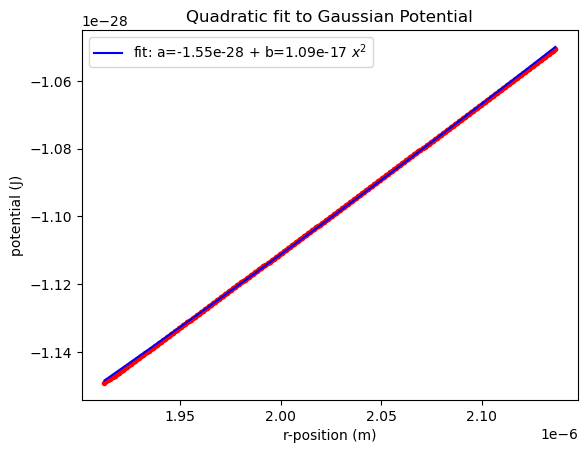

In [6]:
#fitting the potential vector to a quadratic function
from scipy import optimize

def quadratic(x,a,b):
    return a+b*(x**2)
xdata = r_pos
ydata = a

popt, pcov = optimize.curve_fit(quadratic, xdata, ydata)

print(popt,pcov)

plt.plot(xdata,ydata,'r.')
plt.plot(xdata,quadratic(xdata, *popt) ,'b-',label=f'fit: a={popt[0]:.2e} + b={popt[1]:.2e} $x^{{2}}$')
plt.xlabel("r-position (m)")
plt.ylabel("potential (J)")
plt.title("Quadratic fit to Gaussian Potential")
plt.legend()
plt.show()

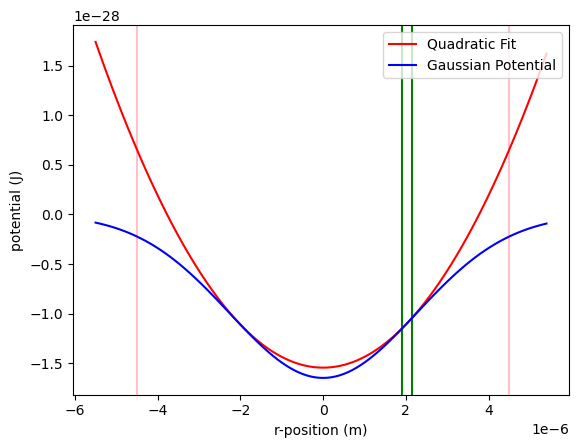

In [7]:

FWHM = 4.5e-6
r_pos = np.arange((-5.5)*1e-6,(5.5)*1e-6,0.1e-6)

intens = intensity(P0,FWHM,z_pos,r_pos,lambda_beam)
a =  potential_position_dependent(omega_res,linewidths,omega_tweezer,intens)  
plt.axvline(x=(FWHM/2)*0.85, color='g', linestyle='-')   
plt.axvline(x=(FWHM/2)*(0.95), color='g', linestyle='-') 
plt.axvline(x = FWHM,color = 'pink')
plt.axvline(x = -FWHM,color = 'pink') 
plt.xlabel("r-position (m)")
plt.ylabel("potential (J)") 
plt.plot(r_pos,quadratic(r_pos, *popt) ,'r-',label="Quadratic Fit")
plt.plot(r_pos,a,'b-',label = "Gaussian Potential")
plt.legend(loc = 'upper right')

In [8]:
(FWHM/2)*0.85

1.9125e-06

In [9]:
#popt[1] should be 1/2*k, so omega = sqrt(k/m)
fit = np.sqrt(2*popt[1]/m)
print(fit)
#I thought the fit from above should match the frequency found from below, since it's using the same beam params
P0 = 5e-3
test = tweezer_optical_potential_to_trap_frequency(lambda_beam,linewidths,omega_res,P0,FWHM,m)
print(test[0])
print(fit/test[0])

18090.443150938423
22156.72074805287
0.8164765606177624


In [10]:
#calculating the r-squared value of the fit
alpha_x = tuple(popt)[1]
residuals = ydata-  quadratic(xdata, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

0.9998651552427896


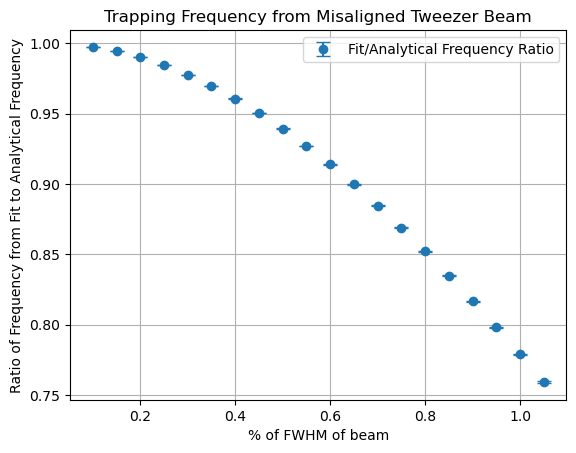

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize


dial_values = np.arange(0.1, 1.1, 0.05)  
results = []
ratios = []
errors = []  # To store the errors for the ratio
P0 = 5e-3
FWHM = 4.5e-6
z_pos = 0
lambda_beam = 532e-9

num_points = 100  # Define the number of points for `r_pos`
for dial in dial_values:
    # Calculate r_pos for each dial value
    r_max = (FWHM / 2) * (dial + dial * 0.025) 
    r_min = (FWHM / 2) * (dial - dial * 0.025) 
    r_pos = np.linspace(r_min, r_max, num_points)

    # Calculate ydata based on r_pos
    ydata = potential_position_dependent(omega_res, linewidths, omega_tweezer, intensity(P0, FWHM, z_pos, r_pos, lambda_beam))

    # Directly use r_pos and ydata for fitting (assuming they always match in length)
    xdata = r_pos
    popt, pcov = optimize.curve_fit(quadratic, xdata, ydata)

    # Calculate the fit-based radial frequency
    fit = np.sqrt(2 * popt[1] / m)

    # Estimate error from the covariance matrix for popt[1]
    perr = np.sqrt(np.diag(pcov))
    fit_error = np.abs(fit * (perr[1] / popt[1]))

    # Use the tweezer_optical_potential_to_trap_frequency function to get the analytical radial frequency
    analytical = tweezer_optical_potential_to_trap_frequency(lambda_beam, linewidths, omega_res, P0, FWHM, m)

    # Calculate the ratio of fit to analytical frequency and collect data for plotting
    ratio = fit / analytical[0]
    ratio_error = fit_error / analytical[0]

    results.append((dial, ratio))
    ratios.append(ratio)  # Collect ratios for plotting
    errors.append(ratio_error)  # Collect errors for error bars

# Plot the dial values against the ratios with error bars
plt.errorbar(dial_values, ratios, yerr=errors, fmt='o', label='Fit/Analytical Frequency Ratio', capsize=5)
plt.xlabel('% of FWHM of beam')
plt.ylabel('Ratio of Frequency from Fit to Analytical Frequency')
plt.title('Trapping Frequency from Misaligned Tweezer Beam')
plt.legend()
plt.grid(True)
plt.show()

# Optionally print the results
# for dial, ratio in results:
#    print(f"Dial: {dial:.2f}, Ratio of fit to analytical frequency: {ratio:.2f}")


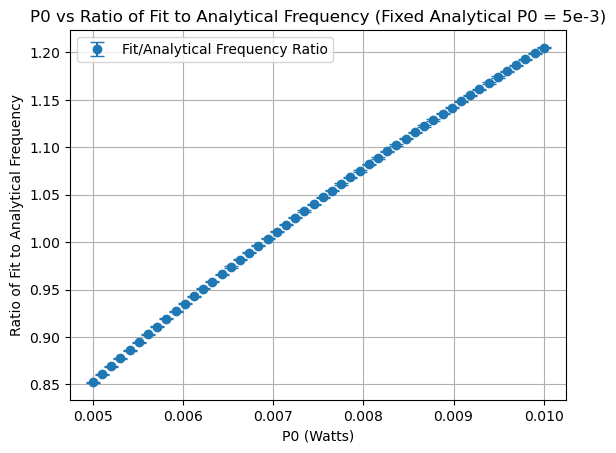

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

# Assuming required functions and variables like 'potential_position_dependent', 'quadratic', 'm', etc., are defined elsewhere

# Define the range for the P0 values (adjust the range and step size as needed)
P0_values = np.linspace(5e-3, 10e-3, 50)  # P0 values ranging from 5 mW to 10 mW
P0_values_miliwatts = P0_values * 1000  # Convert to miliwatts for plotting

# Fixed dial value
dial = 0.8

# Fixed P0 for analytical frequency calculation
P0_analytical = 5e-3

# List to store the results
results = []
ratios = []
errors = []  # To store the errors for the ratio

# Define a fixed number of points for r_pos
num_points = 50  # Fixed number of points for each P0 value

# Calculate the analytical frequency only once using P0_analytical
analytical = tweezer_optical_potential_to_trap_frequency(lambda_beam, linewidths, omega_res, P0_analytical, FWHM, m)

for P0 in P0_values:
    r_max = (FWHM / 2) * (dial + dial * 0.025) 
    r_min = (FWHM / 2) * (dial - dial * 0.025) 
    r_pos = np.linspace(r_min, r_max, num_points)

    # Recalculate ydata for each P0 value
    ydata = potential_position_dependent(omega_res, linewidths, omega_tweezer, intensity(P0, FWHM, z_pos, r_pos, lambda_beam))

    # Use r_pos and ydata for fitting
    xdata = r_pos

    # Perform the fit for the potential
    popt, pcov = optimize.curve_fit(quadratic, xdata, ydata)

    # Calculate the fit-based radial frequency
    fit = np.sqrt(2 * popt[1] / m)

    # Estimate error from the covariance matrix for popt[1]
    perr = np.sqrt(np.diag(pcov))
    fit_error = np.abs(fit * (perr[1] / popt[1]))

    # Calculate the ratio of fit to analytical frequency and collect data for plotting
    ratio = fit / analytical[0]
    ratio_error = fit_error / analytical[0]

    results.append((dial, ratio))
    ratios.append(ratio)  # Collect ratios for plotting
    errors.append(ratio_error)  # Collect errors for error bars

# Plot the P0 values against the ratios
fig, ax = plt.subplots()
#ax.figure(figsize=(8, 6))
ax.errorbar(P0_values, ratios, yerr=errors, fmt='o', label='Fit/Analytical Frequency Ratio', capsize=5)
ax.set_xlabel('P0 (Watts)')
ax.set_ylabel('Ratio of Fit to Analytical Frequency')
ax.set_title('P0 vs Ratio of Fit to Analytical Frequency (Fixed Analytical P0 = 5e-3)')
ax.legend()
ax.grid(True)
#ax.set_xticks(P0_values,labels = P0_values_miliwatts)
plt.show()

# Optionally print a specific P0 and ratio
#print(f"P0: {P0_values[7]:.5f}, Ratio: {ratios[7]:.5f}")


In [13]:
def ion_spacing_test(N,omega_a,tweezed_ion=None):
    """
    Calculating the equilibrium positions of the ions in real units, as well as the distance between each ion
    inputs:
    N = number of ions
    omega_a = rf axial trap frequency [2*Pi x Hz]
    

    returns:
    list where first entry is list of equilibrium positions of ions in meters and second entry is list of distances between ions in meters
    """
    #make it so 
    l = lengthScale(omega_a)
    if tweezed_ion == None:
        ueq = calcPositions(N)*l
    else:
        guess = calcPositions(N)*l
        ueq = fsolve(pot_derivative_with_tweeze,guess,args = (omega_rf_axial,omega_tw_radial,tweezed_ion,displacement))
    
    diff_list = []
    for x, y in zip(ueq[0::], ueq[1::]):
        diff_list.append(y-x)
    return [ueq,diff_list]

In [34]:
def pot_derivative_with_tweeze_test(ion_positions_no_tweezer, omega_rf_axial, omega_tw_radial, tweezed_ion, displacement):
    """
    derivative of the potential energy of the ion chain, use this to find positions of ions in the trap
    This one is specifically for tweezing one ion in the chain
    inputs:

    ion_positions_no_tweezer: list of ion positions without tweezers [m]
    omega_rf_axial: the rf axial trapping frequency [2*pi*Hz]
    omega_tw_radial: the tweezer radial trapping frequency [2*pi*Hz]
    tweezed_ion: Ion number for the tweezed ion, list
    displacement: distance between the tweezer beam center and position of the tweezed ion,list
    """
    pot = []
    N = len(ion_positions_no_tweezer)
    A = 1/2 * m * omega_rf_axial**2
    B = (e**2) /(4 * pi * eps0)
    C = 1/2 * m * omega_tw_radial**2
    for j in range(N):
        each_pot = A*(ion_positions_no_tweezer[j]) 
        - sum([B / (abs(ion_positions_no_tweezer[j] - ion_positions_no_tweezer[n])**2) for n in range(j) if ion_positions_no_tweezer[j] != ion_positions_no_tweezer[n]])  # Avoid division by zero
        + sum([B / (abs(ion_positions_no_tweezer[j] - ion_positions_no_tweezer[n])**2) for n in range(j+1, N) if ion_positions_no_tweezer[j] != ion_positions_no_tweezer[n]])  # Avoid division by zero
        for i in range(len(tweezed_ion)):
            each_pot+= C*(ion_positions_no_tweezer[tweezed_ion[i]] + displacement) if j == tweezed_ion[i] else 0
        pot.append(each_pot)
    return pot



In [35]:
N = 3
tweezed_ion = []
ion_positions_no_tweezer  = ion_spacing_test(N,omega_rf_axial)[0]
omega_rf_axial = 1 * 2 * pi * 1e6
P0 = 5e-3
beam_waist = ion_spacing_test(N,omega_rf_axial)[1][0]*0.8
omega_tw_radial = tweezer_optical_potential_to_trap_frequency(tweezer_wavelength,linewidths,omega_res,P0,beam_waist,m)[0]
tweezed_ion = [0,1]
displacement = [beam_waist*-0.9,beam_waist*0.9]

huh = pot_derivative_with_tweeze_test(ion_positions_no_tweezer, omega_rf_axial, omega_tw_radial, tweezed_ion, displacement)


In [36]:
print(huh)

[array([-6.27798220e-18, -6.27776888e-18]), array([-1.0665882e-22,  1.0665882e-22]), 6.277727401254162e-18]
